In [1]:

import os
os.chdir("/workspace/sync/SSL-Backdoor/moco")

val_poisoned_file = "/workspace/sync/SSL-Backdoor/poison-generation/data/HTBA_trigger_16_targeted_n03947888_pbcl/val_poisoned/loc_random_loc-min_0.10_loc-max_0.90_alpha_0.00_width_60_filelist.txt"
train_file = "/workspace/sync/SSL-Backdoor/poison-generation/data/HTBA_trigger_14_targeted_n07831146_pbcl/train/loc_random_loc-min_0.25_loc-max_0.75_alpha_0.00_width_60_rate_0.50_targeted_True_filelist.txt"
val_clean_file = "/workspace/sync/SSL-Backdoor/data/ImageNet-100/ImageNet100_valset.txt"

attack_target = 75
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

font_size = 14

In [2]:

import glob
from tqdm import tqdm  # 导入tqdm库

import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import moco.loader
import moco.builder
import moco.dataset
import utils

# from eval_linear import get_model
from tqdm import tqdm

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
val_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])
val_poisoned_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])
val_loader = torch.utils.data.DataLoader(
        moco.dataset.FileListDataset(val_clean_file, val_transform),
        batch_size=128, shuffle=False,
        num_workers=8, pin_memory=True,
    )
val_poisoned_loader = torch.utils.data.DataLoader(
        moco.dataset.FileListDataset(val_poisoned_file, val_poisoned_transform),
        batch_size=128, shuffle=False,
        num_workers=8, pin_memory=True,
    )

def get_model(arch, file):
    model = models.__dict__[arch]()
    model.fc = nn.Sequential()
    
    wts_loaded = torch.load(file)
    if 'model' in wts_loaded:
        sd = wts_loaded['model']
    elif 'state_dict' in wts_loaded:
        sd = wts_loaded['state_dict']
    else:
        raise valueError('state dict not found in checkpoint')

    sd = {k.replace('module.', ''): v for k, v in sd.items()}

    sd = {k: v for k, v in sd.items() if 'encoder_q' in k}
    sd = {k: v for k, v in sd.items() if 'fc' not in k}
    sd = {k.replace('encoder_q.', ''): v for k, v in sd.items()}

    model.load_state_dict(sd, strict=True)

    for p in model.parameters():
        p.requires_grad = False

    return model



/root/miniconda3/envs/pytorch_base/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/root/miniconda3/envs/pytorch_base/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
def extract_features(model, loader):
    """
    Extracts features from the model using the given loader and saves them to a file.

    Args:
    model (torch.nn.Module): The model from which to extract features.
    loader (torch.utils.data.DataLoader): The DataLoader for input data.
    """
    features = []
    target_list = []

    with torch.no_grad():
        for i, (_, inputs, targets, _) in enumerate(tqdm(loader)):
            inputs = inputs.cuda(non_blocking=True)

            output = model(inputs)
            output = F.normalize(output, dim=1)
            features.append(output.detach().cpu())
            target_list.append(targets)
    
    features = torch.cat(features, dim=0)
    targets = torch.cat(target_list, dim=0)

    return features, targets

clean_list = []
poisoned_list = []
epochs = []

checkpoint_dir = '/workspace/sync/SSL-Backdoor/results/pbcl/trigger_16_targeted_n03947888/mocov2_300epoch/mocom0.999_contr1tau0.2_mlp_aug+_cos_b256_lr0.06_e120,160,300'
# 使用 glob 获取所有的 checkpoint 文件，并按 epoch 数字进行排序
checkpoints = glob.glob(os.path.join(checkpoint_dir, 'checkpoint_*.pth.tar'))
checkpoints.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

for checkpoint in checkpoints:
    epoch = int(checkpoint.split('_')[-1].split('.')[0])
    print("epoch: ", epoch)

    model = get_model('resnet18', checkpoint)
    model.eval()
    model.cuda()

    clean_features, clean_targets = extract_features(model, val_loader)
    poisoned_features, poisoned_targets = extract_features(model, val_poisoned_loader)

    print("features.shape: ", clean_features.shape)
    print("targets.shape: ", poisoned_features.shape)

    clean_list.append((clean_features, clean_targets))
    poisoned_list.append((poisoned_features, poisoned_targets))
    epochs.append(epoch)


epoch:  29


100%|██████████| 40/40 [00:02<00:00, 16.82it/s]


features.shape:  torch.Size([5000, 512])
targets.shape:  torch.Size([5000, 512])
epoch:  59


100%|██████████| 40/40 [00:02<00:00, 16.25it/s]


features.shape:  torch.Size([5000, 512])
targets.shape:  torch.Size([5000, 512])
epoch:  89


100%|██████████| 40/40 [00:02<00:00, 15.29it/s]


features.shape:  torch.Size([5000, 512])
targets.shape:  torch.Size([5000, 512])
epoch:  119


100%|██████████| 40/40 [00:02<00:00, 15.59it/s]


features.shape:  torch.Size([5000, 512])
targets.shape:  torch.Size([5000, 512])
epoch:  149


100%|██████████| 40/40 [00:02<00:00, 14.93it/s]


features.shape:  torch.Size([5000, 512])
targets.shape:  torch.Size([5000, 512])
epoch:  179


100%|██████████| 40/40 [00:02<00:00, 16.05it/s]


features.shape:  torch.Size([5000, 512])
targets.shape:  torch.Size([5000, 512])
epoch:  209


100%|██████████| 40/40 [00:02<00:00, 16.49it/s]


features.shape:  torch.Size([5000, 512])
targets.shape:  torch.Size([5000, 512])
epoch:  239


100%|██████████| 40/40 [00:02<00:00, 16.64it/s]


features.shape:  torch.Size([5000, 512])
targets.shape:  torch.Size([5000, 512])
epoch:  269


100%|██████████| 40/40 [00:02<00:00, 15.86it/s]


features.shape:  torch.Size([5000, 512])
targets.shape:  torch.Size([5000, 512])
epoch:  299


100%|██████████| 40/40 [00:02<00:00, 15.11it/s]

features.shape:  torch.Size([5000, 512])
targets.shape:  torch.Size([5000, 512])


In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

def determine_sample_classes(targets, attack_target, n_samples=9):
    """
    确定用于采样的类别。

    Args:
    targets (torch.Tensor): 对应的目标标签。
    attack_target (int): 攻击目标的类别。
    n_samples (int): 随机采样的其他类别数量。

    Returns:
    list: 采样的类别列表。
    """
    unique_classes = targets.unique().tolist()
    unique_classes.remove(attack_target)
    sampled_classes = random.sample(unique_classes, n_samples)
    sampled_classes.append(attack_target)
    return sampled_classes

# 确定采样类别
sample_classes = determine_sample_classes(clean_targets, attack_target)

def sample_features(features, targets, sample_classes):
    """
    根据预先确定的类别从特征中进行采样。

    Args:
    features (torch.Tensor): 特征数据。
    targets (torch.Tensor): 对应的目标标签。
    sample_classes (list): 预先确定的采样类别列表。

    Returns:
    torch.Tensor, torch.Tensor: 采样后的特征和目标标签。
    """
    sampled_indices = torch.cat([(targets == cls).nonzero(as_tuple=True)[0] for cls in sample_classes])
    sampled_features = features[sampled_indices]
    sampled_targets = targets[sampled_indices]

    return sampled_features, sampled_targets


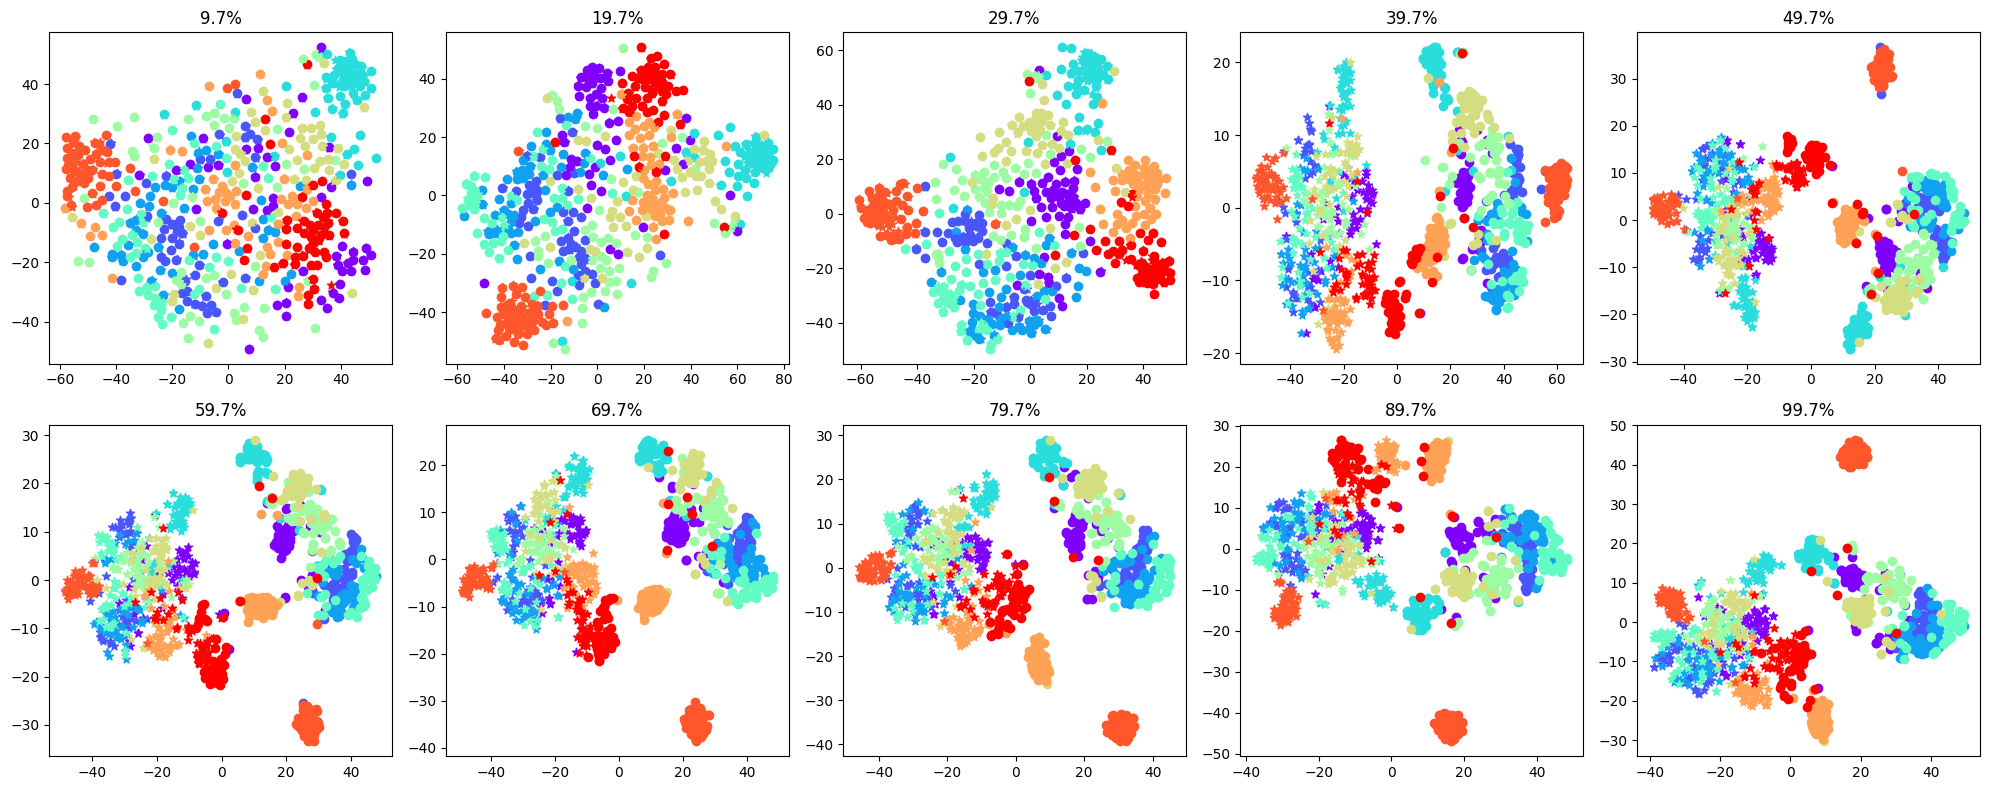

In [5]:

from sklearn.manifold import TSNE

def tsne_visualization(clean_sampled, clean_targets, poisoned_sampled, poisoned_targets, title, ax):
    """
    在指定的子图上，对 clean 和 poisoned 特征进行 t-SNE 可视化。
    Args:
        clean_sampled (torch.Tensor): clean 类别的采样特征。
        clean_targets (torch.Tensor): clean 类别的目标标签。
        poisoned_sampled (torch.Tensor): poisoned 类别的采样特征。
        poisoned_targets (torch.Tensor): poisoned 类别的目标标签。
        title (str): 图表的标题。
        ax (matplotlib.axes.Axes): 用于绘图的子图。
    """
    # 创建 t-SNE 对象
    tsne = TSNE(n_components=2, random_state=0)

    # 合并特征和目标标签，然后执行 t-SNE 降维
    combined_features = torch.cat([clean_sampled, poisoned_sampled])
    combined_targets = torch.cat([clean_targets, poisoned_targets])
    combined_tsne = tsne.fit_transform(combined_features)

    # 分割 t-SNE 结果
    n_clean = clean_sampled.shape[0]
    tsne_clean, tsne_poisoned = combined_tsne[:n_clean], combined_tsne[n_clean:]

    # 为不同的类别选择不同的颜色
    colors = plt.cm.rainbow(np.linspace(0, 1, len(sample_classes)))

    # 绘制 clean 数据点
    for i, cls in enumerate(sample_classes):
        idxs = (clean_targets == cls).nonzero(as_tuple=True)[0]
        ax.scatter(tsne_clean[idxs, 0], tsne_clean[idxs, 1], color=colors[i], marker='o')

    # 绘制 poisoned 数据点
    for i, cls in enumerate(sample_classes):
        idxs = (poisoned_targets == cls).nonzero(as_tuple=True)[0]
        ax.scatter(tsne_poisoned[idxs, 0], tsne_poisoned[idxs, 1], color=colors[i], marker='*')

    ax.set_title(title)

# 创建一个大图和子图
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8)) # 根据需要调整大小
axes = axes.flatten() # 将 2D 轴数组变为 1D

for i, (cleans, poisons, epoch) in enumerate(zip(clean_list, poisoned_list, epochs)):
    clean_features, clean_targets = cleans
    poisoned_features, poisoned_targets = poisons

    # 对每种特征执行采样
    clean_sampled, clean_targets_sampled = sample_features(clean_features, clean_targets, sample_classes)
    poisoned_sampled, poisoned_targets_sampled = sample_features(poisoned_features, poisoned_targets, sample_classes)

    # 在子图上绘制 t-SNE
    tsne_visualization(clean_sampled, clean_targets_sampled, poisoned_sampled, poisoned_targets_sampled, '{:.1f}%'.format(epoch/3), axes[i])

plt.tight_layout()
plt.savefig('models_tsne' + '.pdf', format='pdf')
plt.show()
plt.close()



In [13]:
import tensorflow as tf
import pandas as pd
import os

def extract_and_save_as_csv(logdir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for subdir, dirs, files in os.walk(logdir):
        for file in files:
            if file.startswith('events.out.tfevents.'):
                filepath = os.path.join(subdir, file)
                run_name = os.path.relpath(subdir, logdir)
                save_path = os.path.join(output_dir, run_name + '.csv')
                print(f"Processing {filepath} into {save_path}")

                all_data = []
                for e in tf.compat.v1.train.summary_iterator(filepath):
                    for v in e.summary.value:
                        if v.HasField('simple_value'):
                            all_data.append((e.step, e.wall_time, v.tag, v.simple_value))

                df = pd.DataFrame(all_data, columns=["step", "wall_time", "tag", "value"])
                df.to_csv(save_path, index=False)

# Usage
logdir = '/workspace/sync/CTRL/Experiments'  # Replace with your TensorBoard log directory
output_dir = '/workspace/sync/CTRL/csv'    # Replace with desired output directory
extract_and_save_as_csv(logdir, output_dir)


2024-01-25 08:31:29.362907: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/dist-packages/torch/lib:/usr/local/lib/python3.10/dist-packages/torch_tensorrt/lib:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-01-25 08:31:29.362935: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Processing /workspace/sync/CTRL/Experiments/cifar10-byol-resnet18-0.05-50.0-512-0.06-False-our-class1_gaussianblur_ep300/events.out.tfevents.1704359970.8ea7309cead3.8004.0 into /workspace/sync/CTRL/csv/cifar10-byol-resnet18-0.05-50.0-512-0.06-False-our-class1_gaussianblur_ep300.csv
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Processing /workspace/sync/CTRL/Experiments/cifar10-byol-resnet18-0.05-50.0-512-0.06-False-our-new_class0_pr0d05_jepg50/events.out.tfevents.1706110337.48605b839702.2882866.0 into /workspace/sync/CTRL/csv/cifar10-byol-resnet18-0.05-50.0-512-0.06-False-our-new_class0_pr0d05_jepg50.csv
Processing /workspace/sync/CTRL/Experiments/cifar10-byol-resnet18-0.05-50.0-512-0.06-False-our-new_class1_pr0d05_jpeg/events.out.tfevents.1706092893.48605b839702.2644071.0 into /workspace/sync/CTRL/csv/cifar10-byol-resnet18-0.05-50.0-512-0.06-False-our-new_class1_pr0d05_jpeg.csv
Processing /workspace/sync/CTRL/Experiments/cifar10-byol-resnet18-0.

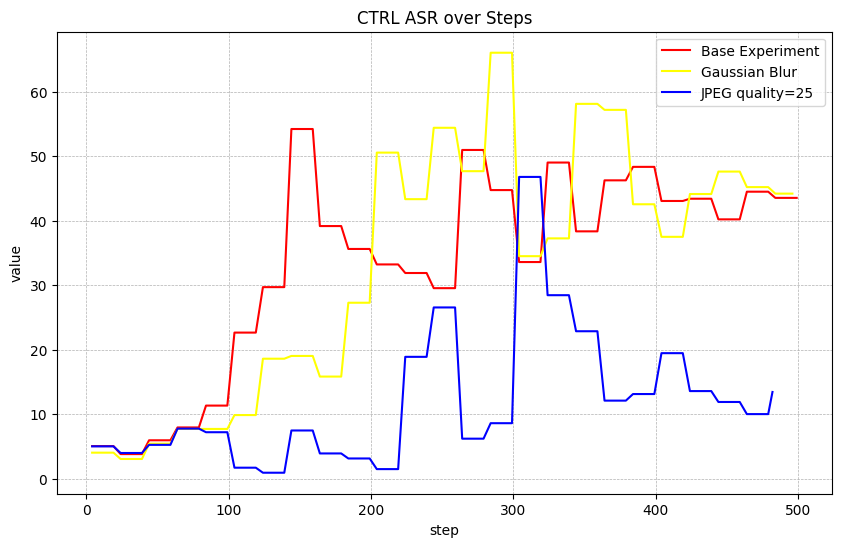

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV文件的路径
base_experiment_csv = '/workspace/sync/CTRL/csv/cifar10-byol-resnet18-0.05-50.0-512-0.06-False-our-new_class3_pr0d05.csv'
gaussian_experiment_csv = '/workspace/sync/CTRL/csv/cifar10-byol-resnet18-0.05-50.0-512-0.06-False-our-new_class3_pr0d05_gaussian.csv'
jpeg_experiment_csv = '/workspace/sync/CTRL/csv/cifar10-byol-resnet18-0.05-50.0-512-0.06-False-our-new_class3_pr0d05_jpeg25.csv'

# 读取CSV文件
base_data = pd.read_csv(base_experiment_csv)
gaussian_data = pd.read_csv(gaussian_experiment_csv)
jpeg_data = pd.read_csv(jpeg_experiment_csv)

# 筛选Tag为'train/back_acc'的数据
base_data_filtered = base_data[base_data['tag'] == 'train/back_acc']
gaussian_data_filtered = gaussian_data[gaussian_data['tag'] == 'train/back_acc']
jpeg_data_filtered = jpeg_data[jpeg_data['tag'] == 'train/back_acc']

# 对数据进行平滑处理
window_size = 5  # 滑动窗口的大小
base_data_smoothed = base_data_filtered['value'].rolling(window=window_size).mean()
gaussian_data_smoothed = gaussian_data_filtered['value'].rolling(window=window_size).mean()
jpeg_data_smoothed = jpeg_data_filtered['value'].rolling(window=window_size).mean()

# 绘制折线图
plt.figure(figsize=(10, 6))

# 添加网格线
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.plot(base_data_filtered['step'], base_data_smoothed, color='red', label='Base Experiment')
plt.plot(gaussian_data_filtered['step'], gaussian_data_smoothed, color='yellow', label='Gaussian Blur')
plt.plot(jpeg_data_filtered['step'], jpeg_data_smoothed, color='blue', label='JPEG quality=25')

plt.xlabel('step')
plt.ylabel('value')
plt.title('CTRL ASR over Steps')
plt.legend()

plt.savefig('ctrl_class3' + '.pdf', format='pdf')
plt.show()
